In [1]:
import geopandas as gpd
import pandas as pd 
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
import process as fe
import pickle as pkl

# Filtering Arrests 

This notebook will walk through the process of geographically filtering a data set of 'theft of services' arrests and turn it into a data set of 'fare evasion' arrests by comparing their locations to that of subway stations.

## Loading Data

Using a few helper functions in `process` to load the datasets we'll be using

In [2]:
thefts_of_service = fe.load_tos_arrests()

thefts_of_service

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,geometry
1,173114463,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0.0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,POINT (-73.91024 40.76944)
48,173113521,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,M,19,1.0,25-44,F,WHITE HISPANIC,995369.0,221138.0,40.773650,-73.959857,POINT (-73.95986 40.77365)
50,173114460,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,M,24,0.0,25-44,M,BLACK,992586.0,227883.0,40.792167,-73.969896,POINT (-73.96990 40.79217)
165,173114446,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,B,40,1.0,25-44,M,WHITE HISPANIC,1011485.0,237929.0,40.819702,-73.901603,POINT (-73.90160 40.81970)
365,173093896,2017-12-30,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,B,52,1.0,25-44,M,BLACK,1013465.0,254827.0,40.866076,-73.894376,POINT (-73.89438 40.86608)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5012081,191748723,2019-01-02,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,M,1,1.0,45-64,M,BLACK,980772.0,194845.0,40.701489,-74.012545,POINT (-74.01254 40.70149)
5012138,191775988,2019-01-02,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,B,40,1.0,18-24,M,BLACK,1007034.0,236608.0,40.816089,-73.917689,POINT (-73.91769 40.81609)
5012222,191744335,2019-01-02,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,B,48,1.0,25-44,M,BLACK HISPANIC,1019444.0,245654.0,40.840877,-73.872807,POINT (-73.87281 40.84088)
5012436,191735303,2019-01-01,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,M,23,0.0,25-44,M,BLACK,999617.0,225524.0,40.785682,-73.944510,POINT (-73.94451 40.78568)


In [3]:
# Set include arrests to false because we will be saving arrests later. 
stations, _, census, lines, nyc = fe.load_all_data(include_arrests=False)
del _

One of the key parameters is the size of the buffer around each subway station. This will determine which arrests make it into the final fare evasion data set, and therefore is a very important assumption. `get_buffer` handles projecting from latitude-longitude to feet and back. 

I also plot the arrests over New York City to make sure the data looks good.

In [5]:
BUFFER_SIZE = 475

station_buffers = fe.get_buffer(stations, feet=BUFFER_SIZE)

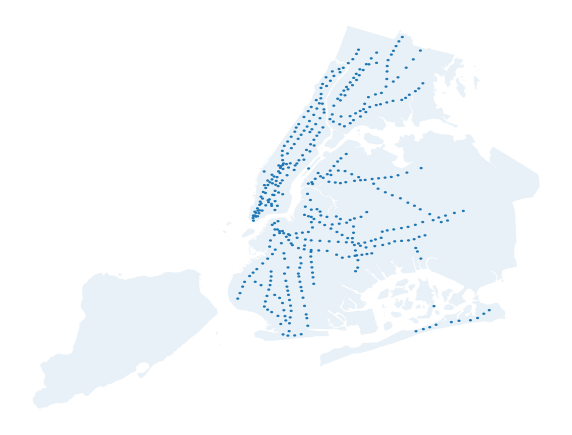

In [6]:
fig, ax = plt.subplots(figsize=(10 ,10))

nyc.plot(ax=ax, alpha=0.1)
station_buffers.geometry.plot(ax=ax)

ax.axis('off');

In [7]:
# For my research, I am only using 2010-present data, so I save some time by filtering to an earlier date

tos = thefts_of_service.copy()

tos = tos[tos['ARREST_DATE'] > pd.datetime(2010, 1, 1)]

One of the most computationally expensive steps is assigning each arrest to a subway station. We can speed up the process significantly by filtering out arrests which did not occur within any of the buffer points first.

## Geographic Filtering

In [8]:
# Create a multipoint of all station buffers

mp = station_buffers.unary_union

In [9]:
# Get the indices of arrests which occur near a subway station

fare_evasion_idx = tos.geometry.intersects(mp)

In [10]:
evasions = tos[fare_evasion_idx]

In [11]:
evasions

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,geometry
48,173113521,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,M,19,1.0,25-44,F,WHITE HISPANIC,995369.0,221138.0,40.773650,-73.959857,POINT (-73.95986 40.77365)
165,173114446,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,B,40,1.0,25-44,M,WHITE HISPANIC,1011485.0,237929.0,40.819702,-73.901603,POINT (-73.90160 40.81970)
365,173093896,2017-12-30,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,B,52,1.0,25-44,M,BLACK,1013465.0,254827.0,40.866076,-73.894376,POINT (-73.89438 40.86608)
420,173102770,2017-12-30,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,M,30,1.0,25-44,M,BLACK,999539.0,239499.0,40.824040,-73.944760,POINT (-73.94476 40.82404)
531,173107288,2017-12-30,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,M,6,1.0,45-64,M,BLACK,983985.0,205857.0,40.731715,-74.000958,POINT (-74.00096 40.73171)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5012058,191753702,2019-01-02,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,B,46,1.0,25-44,M,WHITE HISPANIC,1010257.0,248767.0,40.849453,-73.905998,POINT (-73.90600 40.84945)
5012081,191748723,2019-01-02,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,M,1,1.0,45-64,M,BLACK,980772.0,194845.0,40.701489,-74.012545,POINT (-74.01254 40.70149)
5012138,191775988,2019-01-02,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,B,40,1.0,18-24,M,BLACK,1007034.0,236608.0,40.816089,-73.917689,POINT (-73.91769 40.81609)
5012222,191744335,2019-01-02,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,B,48,1.0,25-44,M,BLACK HISPANIC,1019444.0,245654.0,40.840877,-73.872807,POINT (-73.87281 40.84088)


In [12]:
# Save to csv here because the initial filtering is expensive

evasions.to_csv('evasions.csv')

In [16]:
evasion_station = fe.get_station_arrests(evasions, stations, station_buffers)

I'm saving the "thefts of service" data set just in case I want to change buffer/filtering parameters later on without having to load every single arrest into memory.

In [19]:
evasion_station.to_csv('evasions.csv')
thefts_of_service.to_csv('tos.csv')

In [4]:
stations, evasions, census, lines, nyc = fe.load_all_data()

We reload the data on the line above, since if you already have the data sets saved it is quite time-intensive to recreate them. Notice that the `stations` DataFrame has a `arrests` column - this is because by default `load_all_data` populates the `stations` DataFrame every time it's called. This behavior can be changed by passing `include_arrests=False`. 

In [5]:
stations

,complex_nm,trains,station_ct,bcode,stop_lat,stop_lon,tot2007,tot2008,tot2009,tot2010,...,avwken11,avwken12,avwken13,avwken14,avwken15,avwken16,avwken17,srv_notes,geometry,arrests
complex_id,,,,,,,,,,,,,,,,,,,,,
bx001,138 St-Grand Concourse,4 5,1,36005,40.813224,-73.929849,800595.0,864369.0,887662.0,898509.0,...,2526.0,2648.0,2540.0,3017.0,3136.0,3123.0,2793,NaN,POINT (-73.92985 40.81322),163.0
bx002,149 St-Grand Concourse,2 4 5,2,36005,40.818375,-73.927351,3112547.0,3454530.0,3660150.0,3979328.0,...,14022.0,13024.0,14202.0,15326.0,13683.0,12797.0,12623,NaN,POINT (-73.92735 40.81838),593.0
bx003,161 St-Yankee Stadium,B D 4,2,36005,40.827905,-73.925651,7836990.0,8576546.0,8410256.0,8434247.0,...,34258.0,35820.0,35071.0,36176.0,36969.0,35171.0,33398,NaN,POINT (-73.92565 40.82791),3637.0
bx004,167 St,4,1,36005,40.835537,-73.921400,2715327.0,2876058.0,2892398.0,2931947.0,...,11089.0,11188.0,10176.0,10417.0,11942.0,11579.0,9981,NaN,POINT (-73.92140 40.83554),680.0
bx005,167 St,B D,1,36005,40.833771,-73.918440,2834640.0,2920517.0,2874428.0,2907900.0,...,11956.0,11924.0,12887.0,13220.0,12890.0,12775.0,12682,NaN,POINT (-73.91844 40.83377),572.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
qn074,Sutphin Blvd-Archer Av-JFK Airport,E J Z,1,36081,40.700486,-73.807969,6064612.0,6433286.0,6418547.0,6447287.0,...,24498.0,25388.0,26184.0,28862.0,28383.0,28587.0,25234,NaN,POINT (-73.80797 40.70049),1722.0
qn075,Vernon Blvd-Jackson Av,7,1,36081,40.742626,-73.953581,2414808.0,2967358.0,2939995.0,3110952.0,...,9441.0,8612.0,9491.0,10347.0,12582.0,14981.0,14901,NaN,POINT (-73.95358 40.74263),11.0
qn076,Woodhaven Blvd,J Z,1,36081,40.693879,-73.851576,1180476.0,1269407.0,1285768.0,1285323.0,...,4227.0,3835.0,4255.0,5226.0,5388.0,5099.0,3884,NaN,POINT (-73.85158 40.69388),104.0
